In [118]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from datetime import datetime, date, timedelta

import yfinance as yfin
from var import VaR
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
#from yahoofinancials import YahooFinancials

#pd.set_option('display.float_format', '{:.10f}'.format)

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

# Assignment
Create a Github account if you do not already have one and download a VAR library.
Using the library that you have chosen and historical data (available from Yahoo Finance and other sources) calculate the VaR for your  investment portfolio.
Document your work in a presentation and post it to the Discussion Forum and comment on and discuss the document and posted work of others.

# Variables

In [119]:
start_date = datetime(2022, 1, 1)
end_date = datetime.now()
alpha = 0.05

yfin.pdr_override()

#start_date = "2022-01-01"
#end_date = "2023-08-31"
#alpha = 0.01

# Functions

# Load Data

In [120]:
folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w5/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })


folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker','BondName','Class'])[['Shares','Value']].sum()
folio_df.reset_index(inplace=True)
#folio_df['Morningstar_Category'].fillna('Other', inplace=True)
folio_df

,Ticker,BondName,Class,Shares,Value
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive,"106,383.0000","1,000.0000"
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,"14,201.0000",500.0000
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,"49,967.0000",750.0000
3,C_A_S_H,Cash,Cash,"4,469,000.0000","4,469.0000"
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive,"108,468.0000","2,250.0000"
...,...,...,...,...,...
30,VIGI,Vanguard Intl Div Apprec ETF,Economically Sensitive,"40,481.0000","3,000.0000"
31,VNQ,Vanguard Real Estate ETF,Economically Sensitive,"40,221.0000","3,250.0000"
32,VO,Vanguard Mid-Cap ETF,Economically Sensitive,"9,234.0000","2,000.0000"
33,VONG,Vanguard Russell 1000 Growth ETF,Economically Sensitive,"41,501.0000","3,000.0000"


In [121]:
folio_df.groupby(['Class'])[['Value']].sum()

,Value
Class,
Cash,"4,469.0000"
Economically Sensitive,"50,250.0000"
Interest Rate Sensitive,"29,000.0000"


## Calculate Percentage

In [122]:
portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

In [123]:
ticker_lst = list(folio_df['Ticker'])
weights = (folio_df['port_percent'].values)

In [124]:
price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=end_date)
price_df = price_df[['Adj Close']]
price_df.columns = price_df.columns.get_level_values(1)
price_df['C_A_S_H'] = 1

price_df

[*********************100%%**********************]  35 of 35 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No timezone found, symbol may be delisted')


,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2022-01-03,10.4183,36.7510,13.1206,1,NaN,32.6081,35.1562,...,20.7575,23.9542,82.4521,107.5871,246.6520,77.9475,52.7748
2022-01-04,10.4087,36.6256,13.3690,1,NaN,32.6081,35.4690,...,20.7382,23.9542,82.2496,107.4563,246.4671,77.1101,52.7748
2022-01-05,10.3990,36.3122,13.4133,1,NaN,31.6710,34.6969,...,20.6996,23.8771,81.1115,104.3810,240.2957,74.6471,52.7075
2022-01-06,10.3796,36.2943,13.4932,1,NaN,31.6900,34.9129,...,20.6610,23.8097,80.5425,104.4745,240.9089,74.4895,52.6498
2022-01-07,10.3700,36.3480,13.5109,1,NaN,31.4912,34.6871,...,20.6225,23.7519,80.6389,103.7828,239.4682,73.6718,52.5248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,9.2300,34.2600,15.0000,1,19.7800,23.0400,32.2600,...,18.2200,20.6100,72.2400,76.6245,209.5800,68.9900,48.3700
2023-09-26,9.2200,33.8200,14.8800,1,19.4100,22.6100,31.8900,...,18.2000,20.5800,71.4600,75.2281,206.6000,67.8600,48.3300
2023-09-27,9.2000,33.8100,14.8600,1,19.2600,22.4400,32.1000,...,18.1400,20.4800,71.3000,74.7230,207.2900,67.9600,48.2400


In [125]:
percent_df = price_df.pct_change()
percent_df = percent_df[1:]
percent_df.fillna(0, inplace=True)
percent_df.index = pd.to_datetime(percent_df.index)

percent_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2022-01-04,-0.0009,-0.0034,0.0189,0.0000,0.0000,0.0000,0.0089,...,-0.0009,0.0000,-0.0025,-0.0012,-0.0007,-0.0107,0.0000
2022-01-05,-0.0009,-0.0086,0.0033,0.0000,0.0000,-0.0287,-0.0218,...,-0.0019,-0.0032,-0.0138,-0.0286,-0.0250,-0.0319,-0.0013
2022-01-06,-0.0019,-0.0005,0.0060,0.0000,0.0000,0.0006,0.0062,...,-0.0019,-0.0028,-0.0070,0.0009,0.0026,-0.0021,-0.0011
2022-01-07,-0.0009,0.0015,0.0013,0.0000,0.0000,-0.0063,-0.0065,...,-0.0019,-0.0024,0.0012,-0.0066,-0.0060,-0.0110,-0.0024
2022-01-10,-0.0028,0.0047,0.0007,0.0000,0.0000,-0.0066,-0.0028,...,-0.0009,-0.0016,-0.0087,-0.0058,-0.0033,-0.0008,-0.0020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,-0.0065,-0.0003,0.0040,0.0000,-0.0010,-0.0009,0.0031,...,-0.0049,-0.0053,-0.0017,-0.0009,0.0027,0.0052,-0.0072
2023-09-26,-0.0011,-0.0128,-0.0080,0.0000,-0.0187,-0.0187,-0.0115,...,-0.0011,-0.0015,-0.0108,-0.0182,-0.0142,-0.0164,-0.0008
2023-09-27,-0.0022,-0.0003,-0.0013,0.0000,-0.0077,-0.0075,0.0066,...,-0.0033,-0.0049,-0.0022,-0.0067,0.0033,0.0015,-0.0019


In [126]:
price_df.query("index == '2023-09-11 00:00:00'")

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2023-09-11 00:00:00,9.4000,35.2100,15.0100,1,20.7436,24.2468,33.1387,...,18.3700,20.8500,74.1083,80.8038,216.5903,72.2877,49.1800


In [127]:
price_df.corr()

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
ALTVX,1.0000,0.7306,0.0422,NaN,0.5828,0.7124,0.5319,...,0.9614,0.9737,0.7453,0.7125,0.7131,0.5385,0.9368
BLUEX,0.7306,1.0000,0.2824,NaN,0.5420,0.6478,0.6820,...,0.7700,0.7579,0.8364,0.6497,0.8059,0.8658,0.7592
BPLSX,0.0422,0.2824,1.0000,NaN,-0.2181,-0.2469,0.6561,...,-0.0097,-0.0049,0.5657,-0.2412,0.3946,0.4758,0.3235
C_A_S_H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DFAR,0.5828,0.5420,-0.2181,NaN,1.0000,0.9979,0.3313,...,0.7299,0.6825,0.3014,0.9989,0.6128,0.2130,0.2650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VIGI,0.7453,0.8364,0.5657,NaN,0.3014,0.4769,0.8078,...,0.7498,0.7487,1.0000,0.4783,0.8431,0.8276,0.8547
VNQ,0.7125,0.6497,-0.2412,NaN,0.9989,0.9997,0.4497,...,0.7972,0.7715,0.4783,1.0000,0.7198,0.3883,0.5031
VO,0.7131,0.8059,0.3946,NaN,0.6128,0.7154,0.9256,...,0.7472,0.7257,0.8431,0.7198,1.0000,0.8135,0.7293
VONG,0.5385,0.8658,0.4758,NaN,0.2130,0.3851,0.8015,...,0.5703,0.5454,0.8276,0.3883,0.8135,1.0000,0.6747


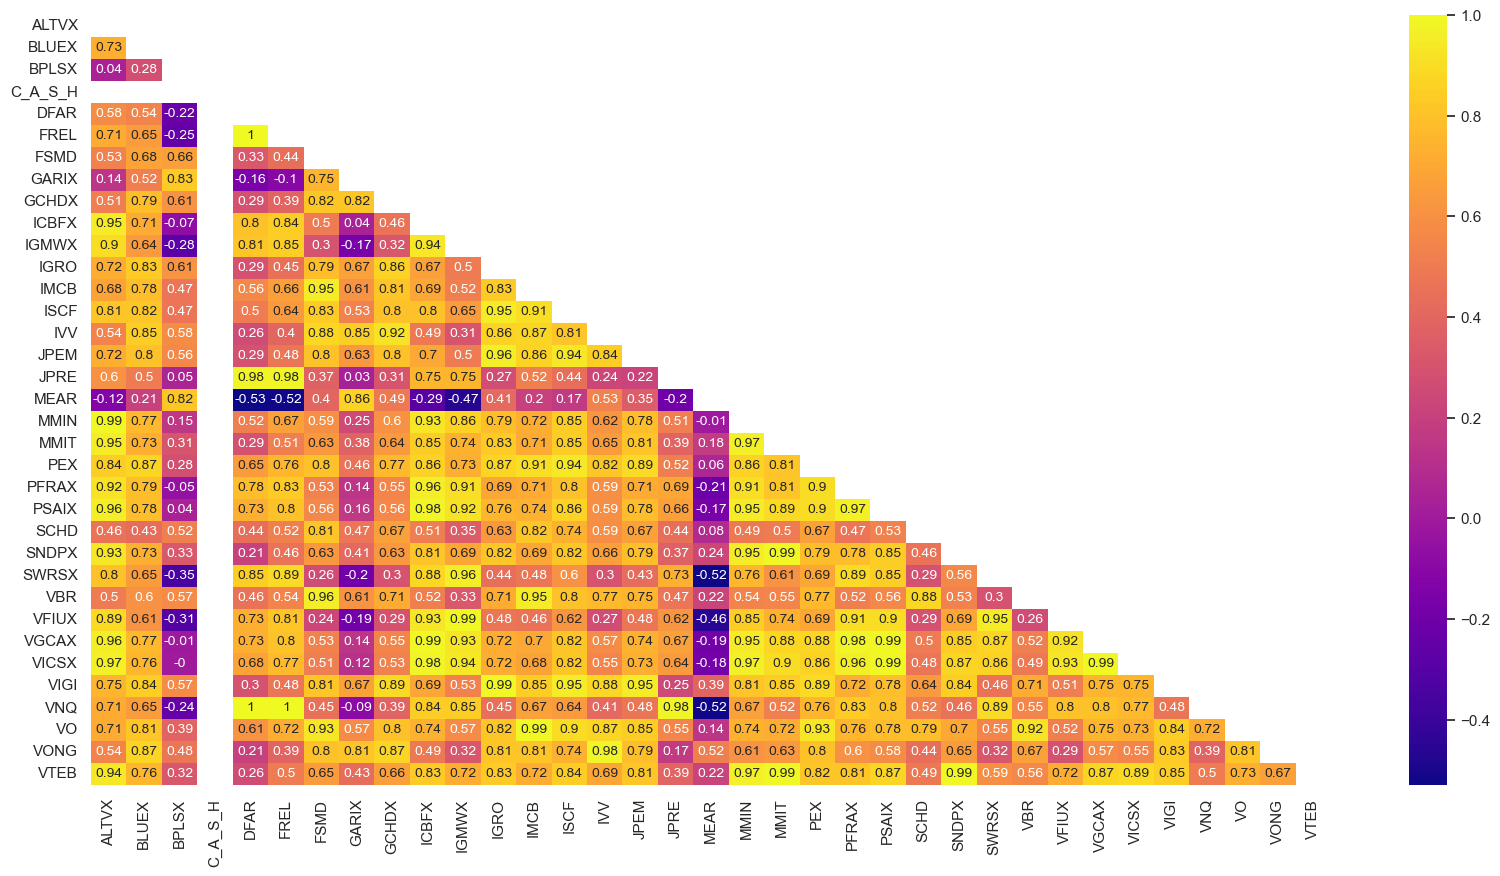

In [128]:
#t_df = df

plt.figure(figsize=(20,10))
mask = np.zeros_like(price_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(price_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

# Calculate Portfolio Values

In [129]:
## Number of Shares

In [130]:
shares_df = folio_df[['Ticker','Shares']]
shares_df.set_index('Ticker', drop=True, inplace=True)
shares_df[['Shares']].round(0)

,Shares
Ticker,
ALTVX,"106,383.0000"
BLUEX,"14,201.0000"
BPLSX,"49,967.0000"
C_A_S_H,"4,469,000.0000"
DFAR,"108,468.0000"
...,...
VIGI,"40,481.0000"
VNQ,"40,221.0000"
VO,"9,234.0000"


## Prices Timeseries

In [131]:
price_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2022-01-03,10.4183,36.7510,13.1206,1,NaN,32.6081,35.1562,...,20.7575,23.9542,82.4521,107.5871,246.6520,77.9475,52.7748
2022-01-04,10.4087,36.6256,13.3690,1,NaN,32.6081,35.4690,...,20.7382,23.9542,82.2496,107.4563,246.4671,77.1101,52.7748
2022-01-05,10.3990,36.3122,13.4133,1,NaN,31.6710,34.6969,...,20.6996,23.8771,81.1115,104.3810,240.2957,74.6471,52.7075
2022-01-06,10.3796,36.2943,13.4932,1,NaN,31.6900,34.9129,...,20.6610,23.8097,80.5425,104.4745,240.9089,74.4895,52.6498
2022-01-07,10.3700,36.3480,13.5109,1,NaN,31.4912,34.6871,...,20.6225,23.7519,80.6389,103.7828,239.4682,73.6718,52.5248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,9.2300,34.2600,15.0000,1,19.7800,23.0400,32.2600,...,18.2200,20.6100,72.2400,76.6245,209.5800,68.9900,48.3700
2023-09-26,9.2200,33.8200,14.8800,1,19.4100,22.6100,31.8900,...,18.2000,20.5800,71.4600,75.2281,206.6000,67.8600,48.3300
2023-09-27,9.2000,33.8100,14.8600,1,19.2600,22.4400,32.1000,...,18.1400,20.4800,71.3000,74.7230,207.2900,67.9600,48.2400


In [132]:
m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
m_df

,Date,Ticker,Price
0,2022-01-03,ALTVX,10.4183
1,2022-01-04,ALTVX,10.4087
2,2022-01-05,ALTVX,10.3990
3,2022-01-06,ALTVX,10.3796
4,2022-01-07,ALTVX,10.3700
...,...,...,...
15325,2023-09-25,VTEB,48.3700
15326,2023-09-26,VTEB,48.3300
15327,2023-09-27,VTEB,48.2400
15328,2023-09-28,VTEB,48.0300


## Add Asset Classes

In [133]:
l_df = folio_df[['Ticker','Class']] #.drop_duplicates() 
l_df

,Ticker,Class
0,ALTVX,Interest Rate Sensitive
1,BLUEX,Economically Sensitive
2,BPLSX,Economically Sensitive
3,C_A_S_H,Cash
4,DFAR,Economically Sensitive
...,...,...
30,VIGI,Economically Sensitive
31,VNQ,Economically Sensitive
32,VO,Economically Sensitive
33,VONG,Economically Sensitive


## Calculate Asset Value Overtime

In [134]:
merg_df = m_df.merge(l_df, how='left', left_on='Ticker', right_on='Ticker').merge(shares_df,how='left' ,left_on='Ticker', right_on='Ticker')
merg_df['share_value'] = merg_df['Price'] * merg_df['Shares']
merg_df

,Date,Ticker,Price,Class,Shares,share_value
0,2022-01-03,ALTVX,10.4183,Interest Rate Sensitive,"106,383.0000","1,108,334.3369"
1,2022-01-04,ALTVX,10.4087,Interest Rate Sensitive,"106,383.0000","1,107,305.0786"
2,2022-01-05,ALTVX,10.3990,Interest Rate Sensitive,"106,383.0000","1,106,276.0232"
3,2022-01-06,ALTVX,10.3796,Interest Rate Sensitive,"106,383.0000","1,104,217.9125"
4,2022-01-07,ALTVX,10.3700,Interest Rate Sensitive,"106,383.0000","1,103,188.7556"
...,...,...,...,...,...,...
15325,2023-09-25,VTEB,48.3700,Interest Rate Sensitive,"20,333.0000","983,507.1883"
15326,2023-09-26,VTEB,48.3300,Interest Rate Sensitive,"20,333.0000","982,693.9272"
15327,2023-09-27,VTEB,48.2400,Interest Rate Sensitive,"20,333.0000","980,863.9541"
15328,2023-09-28,VTEB,48.0300,Interest Rate Sensitive,"20,333.0000","976,593.9652"


In [135]:
t_df = merg_df.groupby(['Date','Class'])[['share_value']].sum().reset_index()
t_df

,Date,Class,share_value
0,2022-01-03,Cash,"4,469,000.0000"
1,2022-01-03,Economically Sensitive,"50,862,544.7504"
2,2022-01-03,Interest Rate Sensitive,"32,415,221.6159"
3,2022-01-04,Cash,"4,469,000.0000"
4,2022-01-04,Economically Sensitive,"50,981,435.3014"
...,...,...,...
1309,2023-09-28,Economically Sensitive,"48,229,242.3354"
1310,2023-09-28,Interest Rate Sensitive,"28,546,307.5982"
1311,2023-09-29,Cash,"4,469,000.0000"
1312,2023-09-29,Economically Sensitive,"48,193,309.1122"


In [136]:
t_df[t_df['Date'] == '2023-09-11']

,Date,Class,share_value
1269,2023-09-11,Cash,"4,469,000.0000"
1270,2023-09-11,Economically Sensitive,"50,250,088.6926"
1271,2023-09-11,Interest Rate Sensitive,"28,999,975.7671"


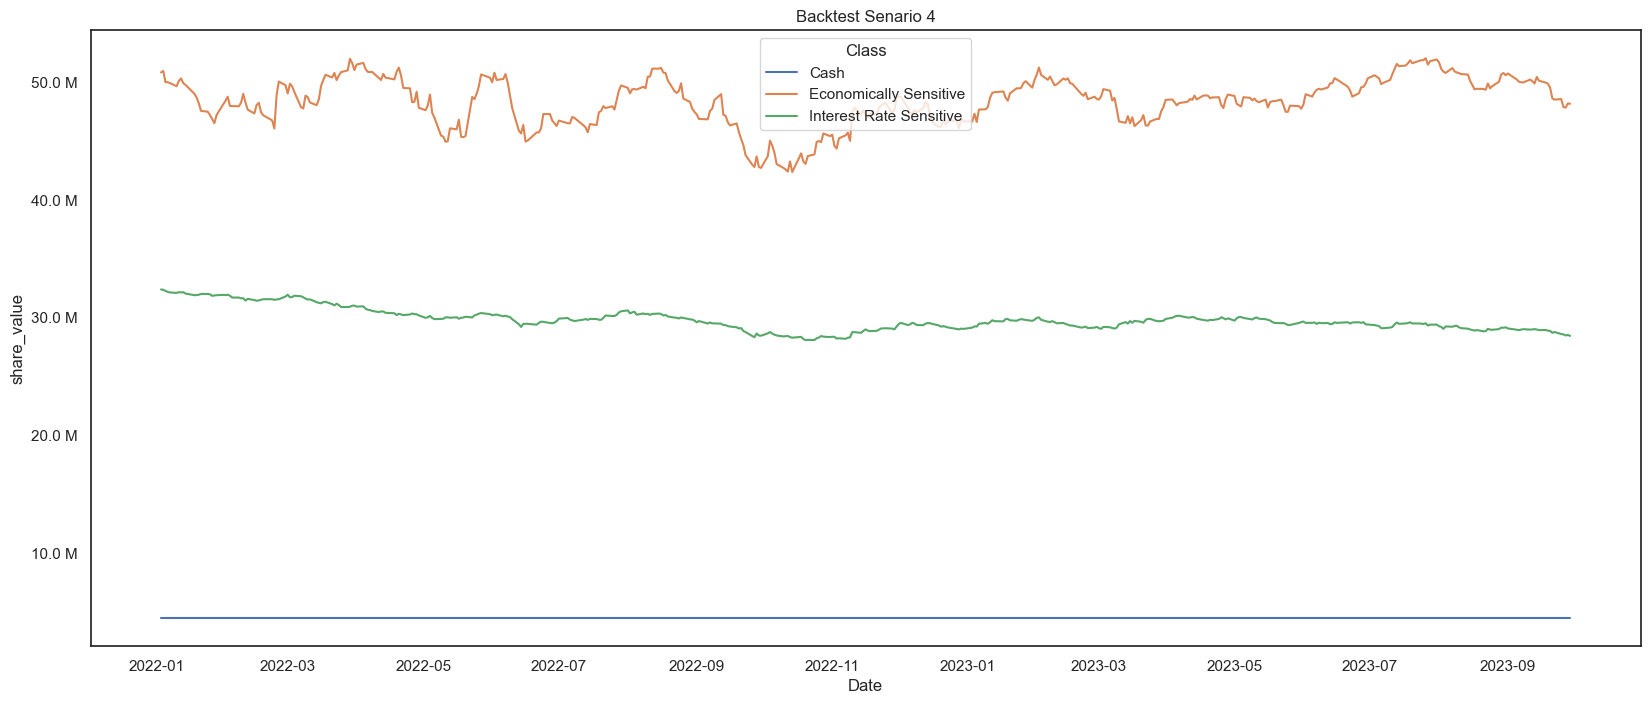

In [137]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
plt.ticklabel_format(style='plain', axis='y')

# Plot
sns.set_style("white")
g = sns.lineplot(data=t_df, x="Date", y="share_value", hue='Class')
g.set_yticklabels(['{:,.1f}'.format(x) + ' M' for x in g.get_yticks()/1000000])

ax.set(title='Backtest Senario 4');

## Asset Class Correlation

In [138]:
s_df = t_df.copy()
s_df = s_df.pivot(index='Date', columns='Class', values='share_value')

s_df

Class,Cash,Economically Sensitive,Interest Rate Sensitive
Date,,,
2022-01-03,"4,469,000.0000","50,862,544.7504","32,415,221.6159"
2022-01-04,"4,469,000.0000","50,981,435.3014","32,381,811.5918"
2022-01-05,"4,469,000.0000","50,032,926.9210","32,289,563.2214"
2022-01-06,"4,469,000.0000","50,027,840.4456","32,208,385.4021"
2022-01-07,"4,469,000.0000","49,949,813.2751","32,157,512.2056"
...,...,...,...
2023-09-25,"4,469,000.0000","48,594,635.3662","28,619,242.2175"
2023-09-26,"4,469,000.0000","47,913,704.2044","28,593,708.2587"
2023-09-27,"4,469,000.0000","47,864,633.1783","28,502,372.2289"


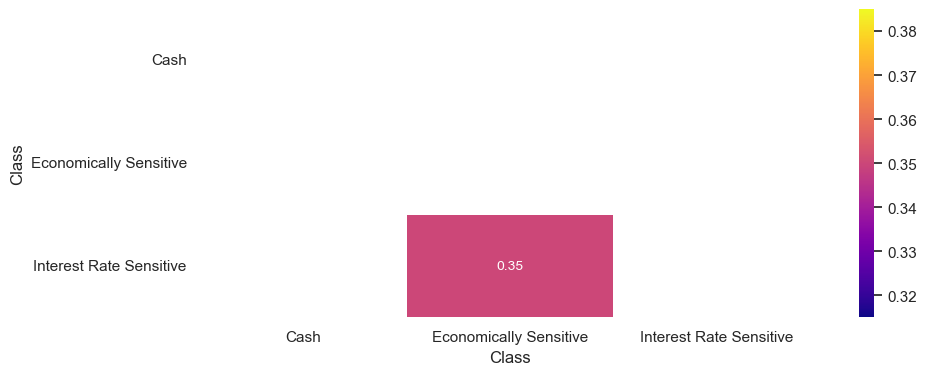

In [139]:
plt.figure(figsize=(10,4))
mask = np.zeros_like(s_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(s_df.corr().round(2), annot=True, mask=mask, cmap="plasma", annot_kws={"size": 10})

# Calculate VaR

In [140]:
l2 = list(folio_df['Ticker'])
l1 = percent_df.columns
list_dif = set(l2).symmetric_difference(set(l1))


print('l1: ', len(l1), 'l2: ', len(l2), 'dif: ', list_dif)

l1:  35 l2:  35 dif:  set()


In [141]:
var = VaR(percent_df, weights, alpha=[0.05,0.025,0.01])
#var = VaR(percent_df, weights, alpha=0.05)
var

<VaR - μ: -0.03%, σ: 0.7151%, Portfolio σ: 0.7159%>

In [142]:
var.info

{'Daily Mean PnL': -0.00025741804339413863,
 'Daily Volatility': 0.007150601883874462,
 'Portfolio Volatility': 0.0071587974188095016}

In [143]:
var.historic()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-29,-0.0123,-0.0148,-0.0180,-0.0158,-0.0184,-0.0216,-0.1772,-0.1835,-0.1862


In [144]:
print('VaR(95.0):', var.historic()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.historic()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -1.2315075343638227
Portfolio VaR(95.0) -1031005.7926940487


In [145]:
var.parametric()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-29,-0.0238,-0.0252,-0.0269,-0.0289,-0.0289,-0.0289,-0.1772,-0.1835,-0.1862


In [146]:
print('VaR(95.0):', var.parametric()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.parametric()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -2.3813632315321978
Portfolio VaR(95.0) -1993653.4838064406


In [147]:
var.monte_carlo()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-29,-0.0120,-0.0143,-0.0170,-0.0151,-0.0171,-0.0195,-0.1772,-0.1835,-0.1862


In [148]:
print('VaR(95.0):', var.monte_carlo()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.monte_carlo()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -1.1991295392246542
Portfolio VaR(95.0) -1008330.0855807732


In [149]:
var.monte_carlo(stressed=True)

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-29,-0.0181,-0.0195,-0.0210,-0.0199,-0.0210,-0.0222,-0.4974,-0.5025,-0.5057


# Backtest

In [150]:
bth = var.backtest(method='h')

Backtest: Historic Method: 100%|██████████| 187/187 [00:00<00:00, 3105.94it/s]


In [151]:
var.evaluate(bth)

,Amount,Percent,Mean Deviation,STD Deviation,Min Deviation,Max Deviation
Observations,187,1,0,0,0,0
VaR(95.0),1,0.0053,-0.0025,0.0000,-0.0025,-0.0025
VaR(99.0),0,0.0000,NaN,NaN,NaN,NaN
CVaR(95.0),1,0.0053,-0.0005,0.0000,-0.0005,-0.0005
CVaR(99.0),0,0.0000,NaN,NaN,NaN,NaN
CDaR(95.0),0,0.0000,0,0,0,0
CDaR(99.0),0,0.0000,0,0,0,0


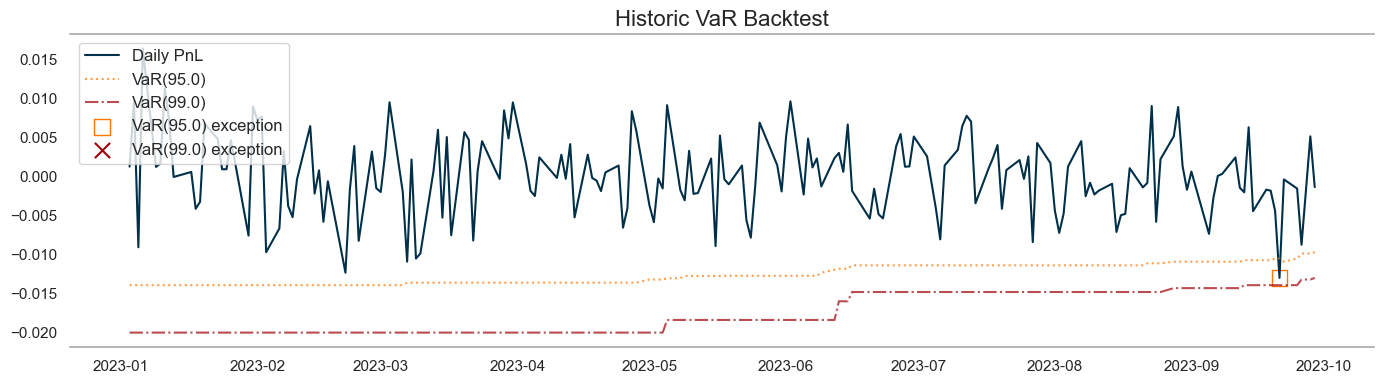

In [152]:
var.var_plot(bth)

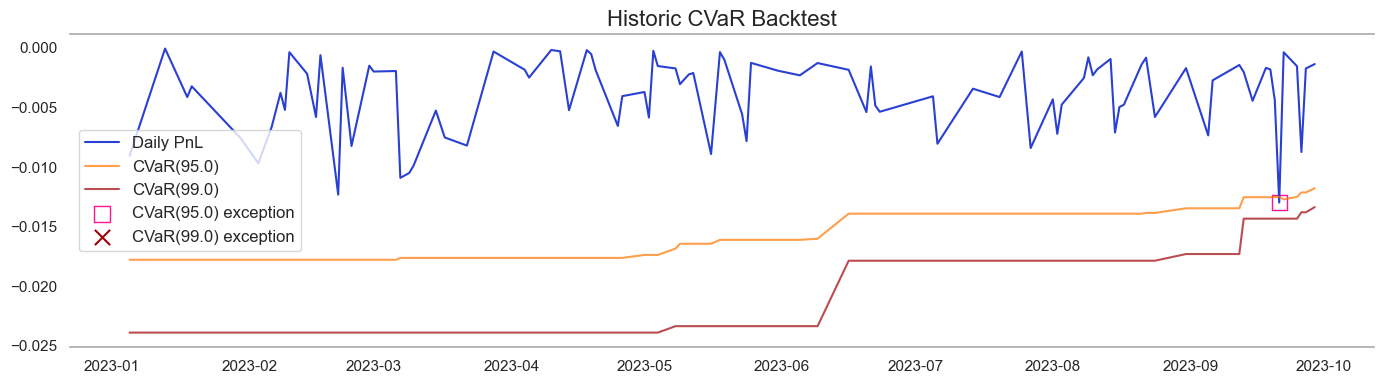

In [153]:
var.cvar_plot(bth)

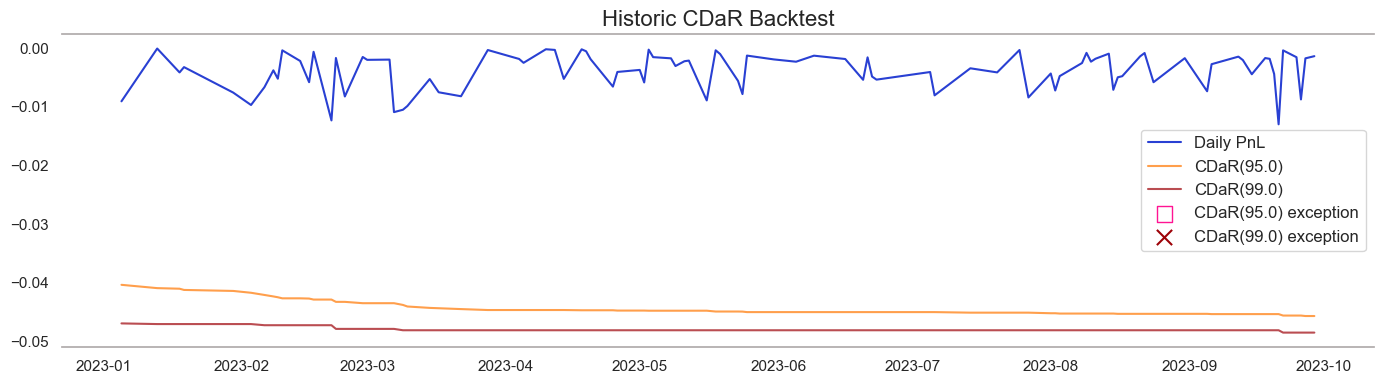

In [154]:
var.cdar_plot(bth)